# Practical 6.1: Variational Autoencoder
In this practical, we will implement a Variational Autoencoder (VAE) step by step. But first, we need to look at a bit of theory to fully define our VAE.

# Theory (part 1)
The following image from one of the papers that originally proposed the VAE (https://arxiv.org/pdf/1312.6114.pdf) shows the graphical model that a VAE represents:

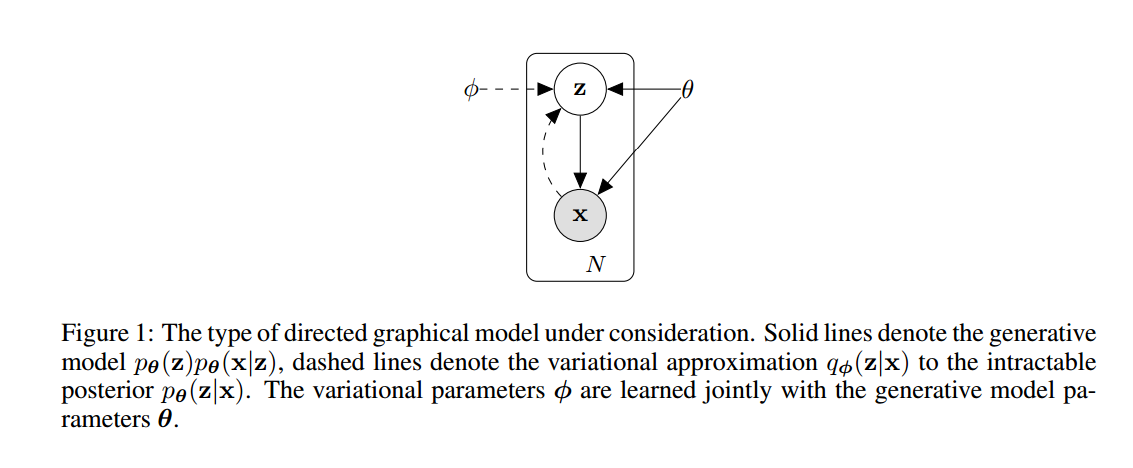

To fully define our VAE, we need to define the following distributions:
* The latent space prior $p(z)$
* The generative/conditional distribution $p(x|z)$
* The variational approximate posterior $q(z|x)$

It is common to use Gaussian (or Normal) distributions, so we will do this too. There are other options too though!


## Latent space prior distribution $p(z)$
We will use a simple prior distribution for the latent variables; a standard factorised Gaussian (Normal) distribution:
\begin{align}
    p(\textbf{z}) &= \mathcal{N}(\textbf{z} | \textbf{0}, I) \\
    &= \prod_{k=1}^K \mathcal{N}(z_k | 0, 1) \\
    &= \prod_{k=1}^K \frac{1}{\sqrt{2\pi}} e^{-\frac{z_k^2}{2}},
\end{align}
where $\textbf{z} = (z_1, \ldots, z_K)^T$, and $K$ is the number of latent dimensions.


## Generative/conditional distribution $p(x|z)$
To create an expressive generative model, we use neural networks to parametrise $p(\textbf{x}|\textbf{z})$. Here, we use a factorised Gaussian (Normal) distribution:
\begin{align}
    p(\textbf{x}|\textbf{z}) &= \mathcal{N}(\textbf{x} | \textbf{m}, \mbox{diag}(\textbf{s}^2)) \\
    &= \prod_{d=1}^D \mathcal{N}(x_d | m_d, s_d^2) \\
    &= \prod_{d=1}^D \frac{1}{\sqrt{2\pi s_d^2}} e^{-\frac{(x_d-m_d)^2}{2s_d^2}},
\end{align}
where the mean parameter $\textbf{m} = (m_1, \ldots, m_D)^T = \textbf{m}(\textbf{z})$ is modelled with a neural network (the **decoder**) that takes latent variables $\textbf{z}$ as inputs, and $D$ is the dimensionality of the data (the number of pixels for image data). Similarly, we could learn the standard deviation parameter $\textbf{s}$ with a neural network as well, but to simplify our model we choose a fixed value $s_d = s$ that is the same for all $d=1, \ldots, D$.

*Note: we use $\textbf{m}$ and $\textbf{s}$ here for the mean and standard deviation parameters of a Gaussian, instead of the more common $\mu$ and $\sigma$, so we can reserve those for the parameters of our approximate posterior (coming up next), to avoid confusion.*

## Approximate posterior distribution $q(z|x)$
For our model, we choose a factorised Gaussian, where both the means and variances are parametrised by neural networks:
\begin{align}
    q(\textbf{z}|\textbf{x}) &= \mathcal{N}(\textbf{z} | \mu, \mbox{diag}(\sigma^2)) \\
    &= \prod_{k=1}^K \mathcal{N}(z_k | \mu_k, \sigma_k^2) \\
    &= \prod_{k=1}^K \frac{1}{\sqrt{2\pi \sigma_k^2}} e^{-\frac{(z_k-\mu_k)^2}{2\sigma_k^2}},
\end{align}
where the mean parameter $\mu = (\mu_1, \ldots, \mu_K)^T = \mu(\textbf{x})$ and standard deviation parameter $\sigma = (\sigma_1, \ldots, \sigma_K)^T = \sigma(\textbf{x})$ are modelled with a neural network (the **encoder**) that takes data points $\textbf{x}$ as inputs.

## Autoencoder structure
Linking all components together, with the chosen distributions, we can see an autoencoder structure emerge:


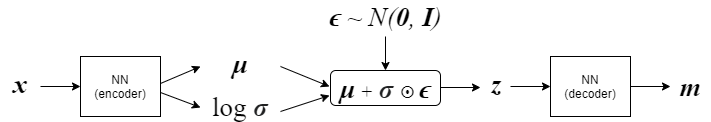

Note that we model $\log \sigma$ as opposed to $\sigma$ for numerical stability (and such that the possible values are all the real numbers, as opposed to only positive numbers).

# Implementation (part 1)
With the distributions defined, let's start implementing the VAE. We will revisit some theory later for the training procedure.

### Imports

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

### Data
We will train a VAE for the MNIST data.

In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalise
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# get number of training samples, height, width, and depth values
n_train, height, width, depth = x_train.shape

11493376/11490434 [==============================] - 0s 0us/step


## Encoder architecture
The encoder has two outputs, which we've seen represent the $\mu$ and $\log \sigma$ parameters of a Gaussian distribution, the approximate posterior.

In this example, we choose a latent space dimension of 2 such that we can easily plot the latent space.

In this example the architecture is a simple network with only fully connected layers. The network is only split up into $\mu$ and $\log\sigma$ at the end, all previous layers are shared.

From https://www.tensorflow.org/tutorials/generative/cvae: "Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling."

### ASSIGNMENT:
Implement the layers whose output represent the parameters $\mu$ and $\log\sigma$. Think about what activation to use (if any).

In [3]:
latent_dim = 2

# VAE model = encoder + decoder
# build encoder model
x_in = layers.Input(shape=(height, width, depth), name='encoder_input')
h = layers.Flatten()(x_in)
h = layers.Dense(500, activation="relu")(h)
h = layers.Dense(500, activation="relu")(h)

#### INSERT CODE HERE ####
z_mu = layers.Dense(latent_dim, name='z_mu')(h)  # mu parameter of q(z|x)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)  # log of sigma parameter of q(z|x)
#### UNTIL HERE ####

# instantiate encoder model
encoder = Model(x_in, [z_mu, z_log_sigma], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          250500      dense[0][0]                      
____________________________________________________________________________________________

## Sampling with the reparameterization trick
To implement sampling with the reparameterization trick, we will define a custom layer. It takes the parameters of $q(z|x)$ as input, and outputs a sample from $q(z|x)$. This is done by first sampling from a standard Gaussian (Normal) distribution, and then applying the proper transformation to obtain a sample from $q(z|x)$ with the given mean and variance.

### ASSIGNMENT:
Implement the missing transformation.

In [0]:
class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mu)), mean=0, stddev=1)
        #### INSERT CODE HERE ####
        return z_mu + K.exp(z_log_sigma) * epsilon
        #### UNTIL HERE ####

# use reparametrisation trick to sample from q(z|x)
z_sample = GaussianSampling(name="z_sample")([z_mu, z_log_sigma])

## Decoder architecture
The input for the encoder is a sample of latent variables, the output represents the parameters of the generative distribution $p(x|z)$, in our case the mean of a Gaussian distribution. Again we use a simple fully connected network for this example.

### ASSIGNMENT:
Implement the layer whose output represents the mean parameter of $p(x|z)$ (before reshaping it). Think about what activation to use (if any), and the size of the output.

In [5]:
# build decoder model
dec_in = layers.Input(shape=(latent_dim,), name='dec_in')


h = layers.Dense(500, activation="relu")(dec_in)
h = layers.Dense(500, activation="relu")(h)
#### INSERT CODE HERE ####
dec_mean = layers.Dense(height * width * depth, activation="sigmoid")(h)
#### UNTIL HERE ####
dec_mean = layers.Reshape((height, width, depth))(dec_mean)

# instantiate decoder model
decoder = Model(dec_in, dec_mean, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_in (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1500      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               392784    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 644,784
Trainable params: 644,784
Non-trainable params: 0
_________________________________________________________________


# Theory (part 2)
Before we setup the loss function for the model, let's revisit a bit of theory.

## Training: Evidence Lower Bound (ELBO)
As we've learned in the course, VAEs are essentially trained with maximum likelihood estimation, i.e. maximising $\log p(X)$ for the dataset $X$, but since this quantity is intractable for a VAE we instead maximise a lower bound to this, the Evidence Lower Bound (ELBO). For a single data point it looks like this:
\begin{align}
    \log p(\textbf{x}) &\geq \mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})] - KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z}))
\end{align}

Neural network training is usually formulated in terms of a loss function that needs to be **minimised**, whereas the ELBO needs to be **maximised**. So, we can simply define our loss function as the negative ELBO:
\begin{align}
    -\mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})] + KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z})).
\end{align}
We look at these two loss terms individually.

## Reconstruction loss term: $-\mathbb{E}_{q(\textbf{z}|\textbf{x})} [\log p(\textbf{x}|\textbf{z})]$
This term contains an expectation over a continuous distribution, which is an integral over a neural network. This is intractable, but can easily be approximated with single-sample Monte Carlo estimation. Or in simpler terms: just sample one value $z$ from the approximate posterior $q(z|x)$ (the encoder with data point $x$ as input), and then compute $- \log p(x|z)$ for that $z$. It's important to realise that this sampling is only possible with the *reparameterization trick* as explained in the course, since every step in the neural network needs to be differentiable to be able to train with stochastic gradient descent.

### MATH ASSIGNMENT:
Write out $- \log p(\textbf{x}|\textbf{z})$ for this factorised Gaussian distribution, and simplify the expression as much as possible.
* Can you relate this expression to a commonly used loss function for neural networks? *(Hint: note that terms that are constant w.r.t. the learned parameters $\mu$ will not affect the learning, as their derivative will be zero.)*
* Do you understand why this term is usually called the reconstruction loss? 
* In particular, what happens if we choose $\sigma = \frac{1}{\sqrt{2}}$?

### SOLUTION:
\begin{align}
    - \log p(\textbf{x}|\textbf{z}) &= - \log \prod_{d=1}^D \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x_d-\mu_d)^2}{2\sigma^2}} \\
    &= -\sum_{d=1}^D \log \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x_d-\mu_d)^2}{2\sigma^2}} \\
    &= \sum_{d=1}^D \left( \frac{(x_d-\mu_d)^2}{2\sigma^2} + \frac{1}{2} \log 2\pi\sigma^2 \right)
\end{align}

Note that the second term is constant w.r.t. the learned parameter $\mu$, so it is not relevant for the gradients of the neural network. So the part that is relevant for training looks like this:
\begin{align}
\sum_{d=1}^D \frac{(x_d-\mu_d)^2}{2\sigma^2}
\end{align}

In particular, if we set $\sigma = \frac{1}{\sqrt{2}}$, it becomes:
\begin{align}
\sum_{d=1}^D (x_d-\mu_d)^2
\end{align}

This is just an element-wise squared error, similar to the common Mean Squared Error (MSE) loss function. There is one key difference though: the "mean" part of MSE would take the mean/average over all pixels $d$, whereas in this case we sum over all $d$ without dividing by the total $D$. The difference is only a scaling, but is important since we have another loss term (the KL Divergence) that needs to be appropriately weighted.

## Second term: $KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z}))$
KL divergence is essentially also an expectation, so it could be approximated with Monte Carlo sampling as well. For two Gaussians (as in our chosen model) however it is possible to compute the KL divergence analytically. It is given as follows (the derivation is left as an exercise to the reader...):
\begin{align}
    KL(q(\textbf{z}|\textbf{x}) || p(\textbf{z})) = \frac{1}{2} \sum_{k=1}^K (\mu_k^2 + \sigma_k^2 - \log \sigma_k^2 - 1).
\end{align}
Gradients w.r.t. $\mu$ and $\sigma$ can be computed exactly for this expression, so it can directly be used in a neural network loss function.

Note that this loss term prevents $\mu$ and $\sigma$ from getting too far away from $\textbf{0}$ and $\textbf{1}$, respectively.

# Implementation (part 2)
We now use the decoder on `z_sample` to obtain the output of the full vae model, and then instantiate this full model. Then we implement the loss terms derived above, and add them to the model.

### ASSIGNMENT:
Implement both loss components.
##### Implementation notes:
* Always use functions from the Keras backend (available through `from tensorflow.keras import backend as K`) for Tensor operations in your loss function (or use their Tensorflow equivalents). This way, Keras can perform automatic differentiation to compute the gradients for training. E.g. `K.sum(), K.square(), K.exp()`. You can use operators such as `+` and `*`, they will automatically convert to Tensor operations.
* Make sure to use `K.batch_flatten(x_in)` and `K.batch_flatten(x_mean)` whenever you need them in your loss functions, don't use `x_in` or `x_mean`. The loss function needs to sum over all pixels, so we don't need the `(height, width, depth)` structure (this structure is useful however if we want to use convolutional layers for the encoder and decoder).
* Note that the formulas we derived are for a single data point or latent variable. Keras however expects a mini-batch of data points or latent variables, so the first dimension in a Tensor is always the batch dimension. For most operations, broadcasting will automatically make computations operate on each data point in a batch individually, but for operations such as `K.sum` you need to make sure you specify the correct axis.
* Given $\log\sigma$, we can compute $\log\sigma^2 = 2\log\sigma$ and $\sigma^2 = e^{2\log\sigma}$ in a efficient and numerically stable way.

In [0]:
x_mean = decoder(z_sample)
vae = Model(x_in, x_mean)

# flatten x_in and x_mean to shape (batch_size, n_pixels)
x_in_flat = K.batch_flatten(x_in)
x_mean_flat = K.batch_flatten(x_mean)
# fixed value for the standard deviation of p(x|z):
x_std = (1 / np.sqrt(2)).astype(np.float32)  # float32 to match Keras Tensors
#### INSERT CODE HERE ####
reconstruction_loss = K.sum(K.square(x_in_flat - x_mean_flat) / (2 * x_std**2) +
                            K.log(x_std) + 0.5 * K.log(2 * np.pi), axis=-1)
kl_loss = 0.5 * K.sum(K.square(z_mu) + K.exp(2 * z_log_sigma) - 2 * z_log_sigma - 1, axis=-1)
#### UNTIL HERE ####

# combine both losses
vae_loss = reconstruction_loss + kl_loss
# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

## Training & evaluating the model
Let's train the model for 50 epochs with batch size 100. On Google Colab, go to Edit > Notebook settings and make sure to select "GPU" as hardware accelerator.

In [7]:
batch_size = 100
epochs = 50

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 496.5003 - val_loss: 491.0190
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 490.0084 - val_loss: 488.8878
Epoch 3/50
600/600 [==============================] - 3s 6ms/step - loss: 488.3628 - val_loss: 487.5374
Epoch 4/50
600/600 [==============================] - 3s 6ms/step - loss: 487.3012 - val_loss: 486.7426
Epoch 5/50
600/600 [==============================] - 3s 6ms/step - loss: 486.5091 - val_loss: 486.2210
Epoch 6/50
600/600 [==============================] - 4s 6ms/step - loss: 485.9223 - val_loss: 485.6537
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 485.4402 - val_loss: 485.5214
Epoch 8/50
600/600 [==============================] - 3s 6ms/step - loss: 485.0100 - val_loss: 484.9007
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 484.7174 - val_loss: 484.7177
Epoch 10/50
600/600 [==============================] - 4s 6ms/st

We can use the following functions to generate plots of the latent space (note that they only work for a 2-dimensional latent space).

The first plot shows the mean representations in latent space for data points from the test set. Although VAEs are unsupervised, we do have label information for the MNIST data, so we can use this give data points a different colour depending on their label.

The second plot takes linearly spaced coordinates in latent space, decodes them into data space representations, and plots them in a grid according to the latent space coordinates. So each of the images are generated, not reconstructed from data.

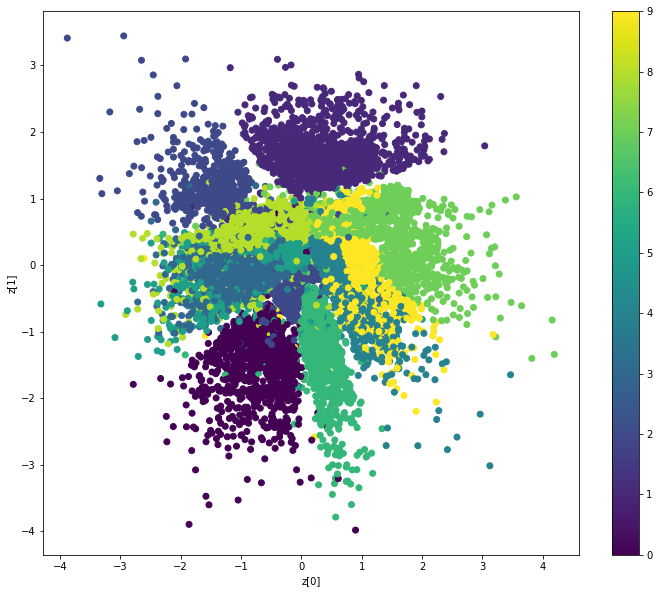

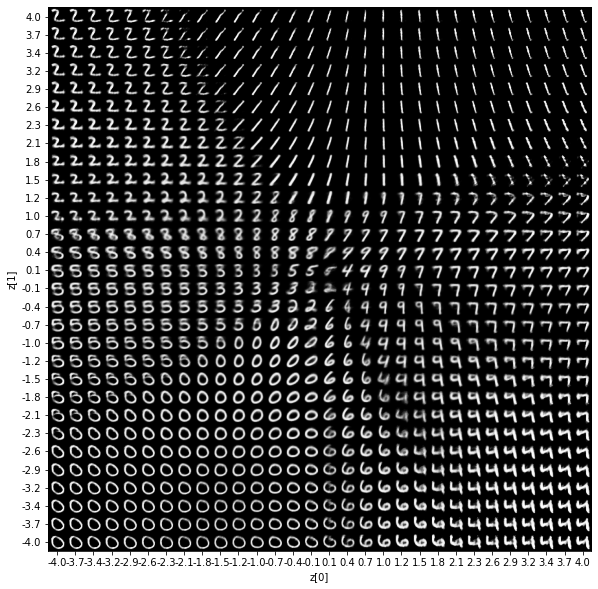

In [8]:
batch_size = 100

def plot_results(encoder, decoder,
                 x_test, y_test,
                 batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mu, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = x_test.shape[1]  # assume square images, i.e. height == width
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# plot results
plot_results(encoder, decoder,
             x_test, y_test,
             batch_size=batch_size)

That's it! We've successfully trained a VAE with Gaussian distributions for MNIST. Of course, we can obtain better results with better architectures for the encoder and decoder. Many ideas for discriminitive models (e.g. classification/regression networks) can be used for the encoder/decoder of a VAE as well, such as convolutions, residual connections, etc. (but typically stochastic methods like Batch Normalization or Dropout are not used in VAEs, as the sampling layer already provides stochasticity).

Note that the VAE is a generative model that can be used in a number of ways:
* Generate data by sampling from the prior first (in our case: sampling Gaussian noise), and then decoding this. Technically this gives us the mean of a Gaussian distribution over pixels. We could sample from this distribution (using the standard deviation per pixel that we set in the loss function), but typically the mean values themselves are used as they already represent an image.
* Obtain latent representations of data by encoding it. In our case this would give $\mu$ and $\log\sigma$ parameters, which we could use to sample from, but typically the $\mu$'s are used directly as the representations. Representations can be useful for a number of tasks, anything related to Representation Learning.
* Reconstruct data. This isn't a particularly useful task in and of itself, but it can give some insight into how well the VAE is trained, and how well the reconstructed data point fits the data that the VAE was trained on.
* Density estimation: the loss function used for training the VAE is a lower bound to the log likelihood of the data ($\log p(x)$). So we can use it as an estimate for the likelihood of unseen data points. Intuitively, a data example that is similar to the data the VAE was trained on should get a higher likelihood value (so a lower loss value), whereas a data example that is very different should get a lower likelihood (so higher loss value). Density estimation is useful various tasks, such as anomaly detection.